In [1]:
import numpy as np
import pandas as pd
import shap
import time
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def type_selector(df):

    continuous_columns = df.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(df[feature].unique())< 20
    ]
    categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    return categorical_columns, continuous_columns

In [3]:
def feature_selector(X):
    continuous_columns = X.select_dtypes(include=[np.number])
    continuous_columns = continuous_columns.columns.to_list()
    #continuous_columns = continuous_columns[1:]

    cat_feature_num = [
        feature for feature in continuous_columns
        if len(X[feature].unique())< 20
    ]
    categorical_columns = X.select_dtypes(include=[np.object]).columns.to_list()
    categorical_columns = list(categorical_columns + cat_feature_num)
    #categorical_columns = categorical_columns[1:]

    continuous_columns = list(set(continuous_columns) - set(categorical_columns))
    
    dummies_features = pd.get_dummies(X[categorical_columns])
    X = pd.concat([X, dummies_features], axis=1)
    dummies_features = dummies_features.columns.tolist()
    X = X.drop(categorical_columns, axis=1)

    return X

In [4]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgbm.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=100,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = catb.Pool(x_train, y_train)
        dvalid = catb.Pool(x_valid, y_valid)

        model = catb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=100
            #categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, encoders, oof_preds

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
client_profile = pd.read_csv('./data/client_profile.csv')

In [7]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [8]:
client_profile = client_profile.rename(columns={ client_profile.columns[0]: "APPLICATION_NUMBER_CLIENT_PL" })

In [9]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X["DAYS_ON_LAST_JOB"] = X["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["EXTERNAL_SCORING_RATING_1"] *\
                                 X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    X["external_scoring_weighted"] = X.EXTERNAL_SCORING_RATING_1 * 2 +\
                                     X.EXTERNAL_SCORING_RATING_2 * 1 + X.EXTERNAL_SCORING_RATING_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['AMOUNT_CREDIT'] / X['AMOUNT_ANNUITY']
    X["ratio_annuity_to_salary"] = X['AMOUNT_ANNUITY'] / X['TOTAL_SALARY']
    X['ratio_credit_to_salary'] = X['AMOUNT_CREDIT'] / X['TOTAL_SALARY']
    X["total_salary_net"] = X["TOTAL_SALARY"] - X["AMOUNT_ANNUITY"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["ratio_credit_to_age"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["ratio_salary_to_age"] = X["TOTAL_SALARY"] / X["AGE"]
    X["ratio_salary_to_experience"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_credit_to_experience"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_annuity_to_experience"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["product_salary_and_region_population"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]
    X["ratio_car_to_experience"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]
    X["ratio_car_to_age"] = X["OWN_CAR_AGE"] / X["AGE"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["expected_total_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["expected_monthly_loss_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["expected_monthly_loss_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]    
    
    #X['NAME_CONTRACT_TYPE'] = np.where(X['NAME_CONTRACT_TYPE'] == 'Cash', 0, 1)
    
    # Композитные признаки
    X['GENDER'] = np.where(X['GENDER'] == 'F', 0, 1)
    X['EDUCATION_LEVEL'] = np.where(X['EDUCATION_LEVEL'].isin(['Higher education', 
                                                               'Academic degree']), 1, 0)
    X['FAMILY_STATUS'] = np.where(X['FAMILY_STATUS'].isin(['Married', 'Widow']), 1, 0)
    X['FAMILY_SIZE'] = np.where(X['FAMILY_SIZE'].isin([1, 2]), 0, 1)    
    X['AMT_REQ_CREDIT_BUREAU_MON'] = np.where(X['AMT_REQ_CREDIT_BUREAU_MON'] == 0, 0, 1)
    X['AMT_REQ_CREDIT_BUREAU_QRT'] = np.where(X['AMT_REQ_CREDIT_BUREAU_QRT'] == 0, 0, 1) 
    X['CHILDRENS'] = np.where(X['CHILDRENS'] == 0, 0, 1)
    
    X.loc[:, 'gender_education'] = X.loc[:, ['GENDER', 'EDUCATION_LEVEL']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    X.loc[:, 'family_status_size'] = X.loc[:, ['FAMILY_STATUS', 'FAMILY_SIZE']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)    
    X.loc[:, 'AMT_REQ_CREDIT_BUREAU_mon_qtr'] = X.loc[:, ['AMT_REQ_CREDIT_BUREAU_MON', 
                                                          'AMT_REQ_CREDIT_BUREAU_QRT']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    X.loc[:, 'children_phone'] = X.loc[:, ['CHILDRENS', 'FLAG_PHONE']].\
                   apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
    
    X.drop(['GENDER', 'EDUCATION_LEVEL',
            'FAMILY_STATUS', 'FAMILY_SIZE',
            'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
            'CHILDRENS', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1, inplace=True)
    
    return X

In [10]:
client_profile = create_client_profile_features(client_profile)
client_profile = client_profile.replace([-np.inf, np.inf], [np.nan, np.nan])

All-NaN slice encountered


In [11]:
client_profile

,APPLICATION_NUMBER_CLIENT_PL,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,...,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,gender_education,family_status_size,AMT_REQ_CREDIT_BUREAU_mon_qtr,children_phone
0,123666076,157500.0,270000.0,13500.0,0.008068,8560,1549.0,NaN,0.329471,0.236315,...,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,0 0,0 0,0 1,0 1
1,123423688,270000.0,536917.5,28467.0,0.020246,23187,NaN,NaN,NaN,0.442295,...,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,0 0,1 0,0 1,0 0
2,123501780,427500.0,239850.0,23850.0,0.072508,14387,326.0,18.0,0.409017,0.738159,...,98102.721947,177047.426953,NaN,9755.054903,17605.091235,NaN,1 0,1 1,1 1,1 0
3,123588799,112500.0,254700.0,17149.5,0.019101,14273,1726.0,12.0,NaN,0.308994,...,NaN,78700.652830,150332.431346,NaN,5299.084593,10122.206641,1 0,1 0,0 0,0 0
4,123647485,130500.0,614574.0,19822.5,0.022625,22954,NaN,NaN,NaN,0.739408,...,NaN,454420.991996,96266.765058,NaN,14656.917009,3104.992971,1 0,1 0,0 0,0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,216000.0,45000.0,2425.5,0.018850,19150,7415.0,NaN,0.555436,0.581592,...,24994.637022,26171.632545,2171.654256,1347.210935,1410.650994,117.052164,1 1,1 0,0 1,0 0
249996,123645397,103500.0,675000.0,28507.5,0.014520,19604,1799.0,16.0,NaN,0.676409,...,NaN,456575.965539,490530.066259,NaN,19282.724945,20716.719798,1 1,1 0,0 0,0 0
249997,123504053,202500.0,1078200.0,38331.0,0.031329,8351,124.0,12.0,NaN,0.353665,...,NaN,381321.264246,305898.151857,NaN,13556.321072,10874.960173,1 0,0 0,0 1,0 0
249998,123547316,135000.0,500211.0,38839.5,0.030755,13277,1603.0,NaN,0.305746,0.682462,...,152937.506607,341375.124646,319988.762179,11875.021317,26506.492568,24845.922078,0 0,1 0,0 0,0 0


In [12]:
def group_by_stat(df,features_list):
    
    for item in features_list:
        df[item+"_mean-"+ "APPLICATION_NUMBER_CLIENT_PL"] = df.groupby(item)['APPLICATION_NUMBER_CLIENT_PL'].transform('mean')
        df[item+"_median-"+ "APPLICATION_NUMBER_CLIENT_PL"] = df.groupby(item)['APPLICATION_NUMBER_CLIENT_PL'].transform('median')
        df[item+"_std-"+ "APPLICATION_NUMBER_CLIENT_PL"] = df.groupby(item)['APPLICATION_NUMBER_CLIENT_PL'].transform('std')
        df[item+"_count_"+ "APPLICATION_NUMBER_CLIENT_PL"] = df.groupby(item)['APPLICATION_NUMBER_CLIENT_PL'].transform('count')
        df[item+"_min-"+ "APPLICATION_NUMBER_CLIENT_PL"] = df.groupby(item)['APPLICATION_NUMBER_CLIENT_PL'].transform('min')
        df[item+"_max_"+ "APPLICATION_NUMBER_CLIENT_PL"] = df.groupby(item)['APPLICATION_NUMBER_CLIENT_PL'].transform('max')
    
    return df

In [13]:
categorical_columns,continuous_columns = type_selector(client_profile.drop('APPLICATION_NUMBER_CLIENT_PL',1))

In [14]:
client_profile_grouped_by_stat= group_by_stat(client_profile,categorical_columns+continuous_columns)

In [15]:
reduce_mem_usage(client_profile_grouped_by_stat)

Memory usage of dataframe is 629.43 MB
Memory usage after optimization is: 315.43 MB
Decreased by 49.9%


,APPLICATION_NUMBER_CLIENT_PL,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,...,total_salary_net_std-APPLICATION_NUMBER_CLIENT_PL,total_salary_net_count_APPLICATION_NUMBER_CLIENT_PL,total_salary_net_min-APPLICATION_NUMBER_CLIENT_PL,total_salary_net_max_APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_mean-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_median-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_std-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_count_APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_min-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_max_APPLICATION_NUMBER_CLIENT_PL
0,123666076,157500.0,270000.0,13500.0,0.008064,8560,1549.0,NaN,0.329590,0.236328,...,88842.726562,458.0,123423824.0,123729416.0,123666080.0,123666080.0,NaN,1.0,123666080.0,123666080.0
1,123423688,270000.0,536917.5,28467.0,0.020248,23187,NaN,NaN,NaN,0.442383,...,162592.984375,3.0,123423688.0,123712928.0,NaN,NaN,NaN,NaN,NaN,NaN
2,123501780,427500.0,239850.0,23850.0,0.072510,14387,326.0,18.0,0.408936,0.738281,...,NaN,1.0,123501776.0,123501776.0,123501776.0,123501776.0,NaN,1.0,123501776.0,123501776.0
3,123588799,112500.0,254700.0,17149.5,0.019104,14273,1726.0,12.0,NaN,0.309082,...,78071.859375,27.0,123423920.0,123709472.0,NaN,NaN,NaN,NaN,NaN,NaN
4,123647485,130500.0,614574.0,19822.5,0.022629,22954,NaN,NaN,NaN,0.739258,...,34237.402344,2.0,123599064.0,123647488.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,216000.0,45000.0,2425.5,0.018845,19150,7416.0,NaN,0.555664,0.581543,...,NaN,1.0,123657256.0,123657256.0,123657256.0,123657256.0,NaN,1.0,123657256.0,123657256.0
249996,123645397,103500.0,675000.0,28507.5,0.014519,19604,1799.0,16.0,NaN,0.676270,...,63376.402344,5.0,123491568.0,123645872.0,NaN,NaN,NaN,NaN,NaN,NaN
249997,123504053,202500.0,1078200.0,38331.0,0.031342,8351,124.0,12.0,NaN,0.353760,...,85736.273438,26.0,123430336.0,123705840.0,NaN,NaN,NaN,NaN,NaN,NaN
249998,123547316,135000.0,500211.0,38839.5,0.030762,13277,1603.0,NaN,0.305664,0.682617,...,69392.812500,14.0,123430712.0,123682080.0,123547312.0,123547312.0,NaN,1.0,123547312.0,123547312.0


In [16]:
client_profile_grouped_by_stat = client_profile_grouped_by_stat.rename(columns={ client_profile_grouped_by_stat.columns[0]: "APPLICATION_NUMBER" })

In [17]:
train = pd.merge(train, client_profile_grouped_by_stat, how='left', on = ['APPLICATION_NUMBER'])
test = pd.merge(test, client_profile_grouped_by_stat, how='left', on = ['APPLICATION_NUMBER'])

In [18]:
train_featured = feature_selector(train.drop('TARGET', 1))
test = feature_selector(test)
train_featured['TARGET'] = train['TARGET']

In [19]:
import re
train_featured = train_featured.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_featured.drop(["TARGET"],1), 
                                                    train_featured['TARGET'], random_state=0)

In [21]:
categorical_columns,continuous_columns = type_selector(train_featured.drop('TARGET',1))

In [22]:
params_lgbm = {"boosting_type": "gbdt",
                  "objective": "binary",
                  "metric": "auc",
                  "num_boost_round": 10000,
                  'colsample_bytree': 0.5157071025553219,
                  'min_child_samples': 468,
                  'min_child_weight': 100.0,               
                  "learning_rate": 0.05,          
                  "class_weight": 'balanced',
                  'early_stopping_rounds':50,
                  'num_leaves': 48,
                  'reg_alpha': 2,
                  'reg_lambda': 50,
                  'subsample': 0.7252600946741159,
                  "max_depth": 5,# попробовать убавить на 4
                  "n_estimators": 5000,
                  "n_jobs": -1,
                  "seed": 27}

In [23]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	training's auc: 0.770219	valid_1's auc: 0.728925


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [24]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


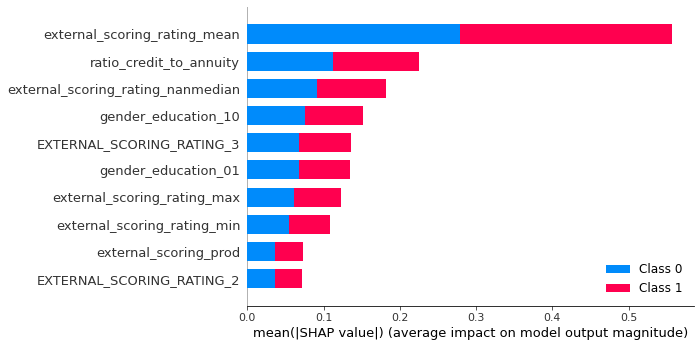

In [25]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_test, X_test,
                      max_display=10, auto_size_plot=None)

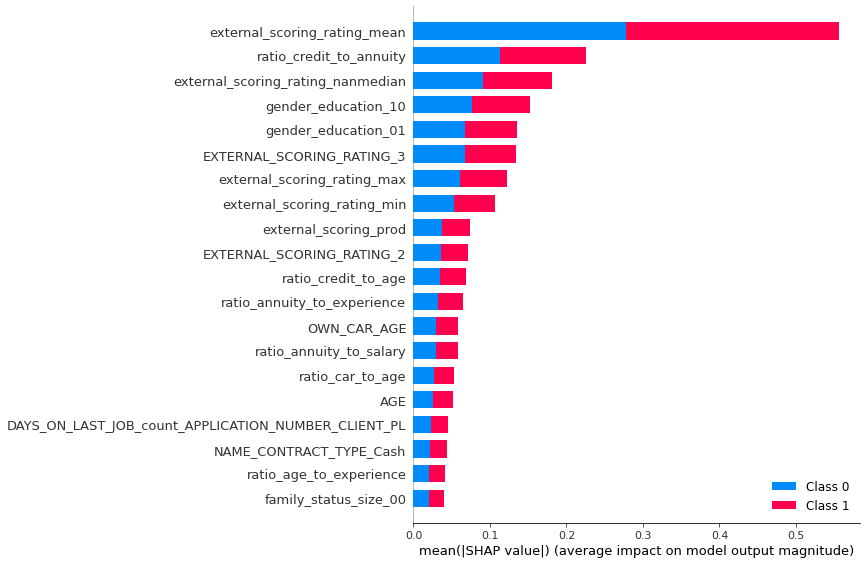

In [26]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [27]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance['feature_importance_vals']
feature_importance

,col_name,feature_importance_vals
18,external_scoring_rating_mean,22941.580031
21,ratio_credit_to_annuity,9290.763630
19,external_scoring_rating_nanmedian,7495.761904
267,gender_education_10,6279.931943
266,gender_education_01,5566.522630
...,...,...
187,ratio_salary_to_age_count_APPLICATION_NUMBER_C...,0.000000
178,ratio_credit_to_annuity_meanAPPLICATION_NUMBER...,0.000000
163,bki_requests_count_count_APPLICATION_NUMBER_CL...,0.000000
160,bki_requests_count_meanAPPLICATION_NUMBER_CLIE...,0.000000


In [30]:
feature_importance['feature_importance_vals'].mean()

530.3805871024234

In [31]:
feature_importance = feature_importance.loc[feature_importance['feature_importance_vals'] > 530]

In [32]:
feature_importance = feature_importance['col_name'].tolist()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train_featured[feature_importance], 
                                                    train_featured['TARGET'], random_state=0)

In [34]:
model = lgbm.LGBMClassifier(**params_lgbm)
model.fit(X_train, y_train, verbose=200 , eval_set=[(X_train, y_train), (X_test, y_test)])

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
Training until validation scores don't improve for 50 rounds
[200]	training's auc: 0.77319	valid_1's auc: 0.727007
Early stopping, best iteration is:
[275]	training's auc: 0.78394	valid_1's auc: 0.727542


LGBMClassifier(class_weight='balanced', colsample_bytree=0.5157071025553219,
               early_stopping_rounds=50, learning_rate=0.05, max_depth=5,
               metric='auc', min_child_samples=468, min_child_weight=100.0,
               n_estimators=5000, num_boost_round=10000, num_leaves=48,
               objective='binary', reg_alpha=2, reg_lambda=50, seed=27,
               subsample=0.7252600946741159)

In [39]:
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,...,total_salary_net_std-APPLICATION_NUMBER_CLIENT_PL,total_salary_net_count_APPLICATION_NUMBER_CLIENT_PL,total_salary_net_min-APPLICATION_NUMBER_CLIENT_PL,total_salary_net_max_APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_mean-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_median-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_std-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_count_APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_min-APPLICATION_NUMBER_CLIENT_PL,expected_monthly_loss_1_max_APPLICATION_NUMBER_CLIENT_PL
0,123687442,0,Cash,157500.0,855000.0,25128.0,0.019104,15728.0,1719.0,11.0,...,90684.390625,13.0,123430864.0,123700952.0,123687440.0,123687440.0,NaN,1.0,123687440.0,123687440.0
1,123597908,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123526683,0,Cash,135000.0,1006920.0,42660.0,0.026398,21557.0,3618.0,NaN,...,88193.851562,21.0,123438384.0,123725800.0,NaN,NaN,NaN,NaN,NaN,NaN
3,123710391,1,Cash,180000.0,518562.0,22972.5,0.031342,22338.0,NaN,NaN,...,81581.468750,5.0,123507320.0,123710392.0,NaN,NaN,NaN,NaN,NaN,NaN
4,123590329,1,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,123672463,0,Cash,175500.0,269550.0,12618.0,0.010033,10519.0,1354.0,NaN,...,NaN,1.0,123672464.0,123672464.0,123672464.0,123672464.0,NaN,1.0,123672464.0,123672464.0
110090,123723001,0,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110091,123554358,0,Cash,270000.0,1024740.0,49428.0,0.019104,15008.0,361.0,22.0,...,95347.101562,11.0,123430520.0,123727056.0,123554360.0,123554360.0,NaN,1.0,123554360.0,123554360.0


In [40]:
test

,APPLICATION_NUMBER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,...,family_status_size_10,family_status_size_11,AMT_REQ_CREDIT_BUREAU_mon_qtr_00,AMT_REQ_CREDIT_BUREAU_mon_qtr_01,AMT_REQ_CREDIT_BUREAU_mon_qtr_10,AMT_REQ_CREDIT_BUREAU_mon_qtr_11,children_phone_00,children_phone_01,children_phone_10,children_phone_11
0,123724268,117000.0,1125000.0,32895.0,0.028656,16007.0,2646.0,20.0,NaN,0.628418,...,1,0,0,1,0,0,1,0,0,0
1,123456549,81000.0,312768.0,17095.5,0.019684,10315.0,459.0,NaN,NaN,0.578125,...,0,1,1,0,0,0,0,0,1,0
2,123428178,157500.0,450000.0,22500.0,0.019104,13016.0,977.0,NaN,NaN,0.152588,...,0,1,0,1,0,0,0,0,0,1
3,123619984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,123671104,90000.0,254700.0,24939.0,0.015221,17743.0,9256.0,NaN,0.71875,0.505859,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
165137,123536402,135000.0,450000.0,16807.5,0.028656,18610.0,10400.0,23.0,NaN,0.666016,...,0,0,1,0,0,0,1,0,0,0
165138,123718238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
165139,123631557,112500.0,350181.0,36769.5,0.030762,20551.0,NaN,NaN,NaN,0.761230,...,1,0,0,0,0,1,1,0,0,0


In [43]:
train_featured

,APPLICATION_NUMBER,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,...,family_status_size_11,AMT_REQ_CREDIT_BUREAU_mon_qtr_00,AMT_REQ_CREDIT_BUREAU_mon_qtr_01,AMT_REQ_CREDIT_BUREAU_mon_qtr_10,AMT_REQ_CREDIT_BUREAU_mon_qtr_11,children_phone_00,children_phone_01,children_phone_10,children_phone_11,TARGET
0,123687442,157500.0,855000.0,25128.0,0.019104,15728.0,1719.0,11.0,0.700684,0.645996,...,1,1,0,0,0,0,0,1,0,0
1,123597908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
2,123526683,135000.0,1006920.0,42660.0,0.026398,21557.0,3618.0,NaN,NaN,0.682129,...,0,0,0,1,0,0,1,0,0,0
3,123710391,180000.0,518562.0,22972.5,0.031342,22338.0,NaN,NaN,NaN,0.171265,...,0,1,0,0,0,1,0,0,0,1
4,123590329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
110089,123672463,175500.0,269550.0,12618.0,0.010033,10519.0,1354.0,NaN,0.528320,0.471680,...,0,1,0,0,0,1,0,0,0,0
110090,123723001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
110091,123554358,270000.0,1024740.0,49428.0,0.019104,15008.0,361.0,22.0,0.653809,0.651367,...,1,0,0,1,0,0,0,1,0,0


In [45]:
train = train_featured.groupby('APPLICATION_NUMBER').mean()
test = test.groupby('APPLICATION_NUMBER').mean()

In [46]:
train = train[feature_importance]
test = test[feature_importance]

In [47]:
test

,external_scoring_rating_mean,ratio_credit_to_annuity,external_scoring_rating_nanmedian,gender_education_10,gender_education_01,EXTERNAL_SCORING_RATING_3,external_scoring_rating_max,external_scoring_rating_min,external_scoring_prod,EXTERNAL_SCORING_RATING_2,...,bki_kurtosis_count_APPLICATION_NUMBER_CLIENT_PL,product_salary_and_region_population_medianAPPLICATION_NUMBER_CLIENT_PL,AMT_REQ_CREDIT_BUREAU_YEAR_medianAPPLICATION_NUMBER_CLIENT_PL,ratio_credit_to_annuity_max_APPLICATION_NUMBER_CLIENT_PL,AGE_count_APPLICATION_NUMBER_CLIENT_PL,OWN_CAR_AGE_stdAPPLICATION_NUMBER_CLIENT_PL,expected_total_loss_2,REGION_POPULATION_stdAPPLICATION_NUMBER_CLIENT_PL,expected_total_loss_3,AMOUNT_CREDIT
APPLICATION_NUMBER,,,,,,,,,,,,,,,,,,,,,
123423342,0.466797,36.218750,0.466797,0,1,NaN,0.622070,0.311279,NaN,0.622070,...,41366.0,123585872.0,123576144.0,123729856.0,13.0,NaN,8.048764e+05,86808.210938,NaN,1293502.5
123423343,0.642578,20.000000,0.642578,1,0,0.729492,0.729492,0.556152,NaN,0.556152,...,41366.0,123621504.0,123576144.0,123730840.0,16.0,89669.007812,7.504813e+04,88823.757812,98491.500000,135000.0
123423344,0.650391,10.531250,0.650391,0,0,NaN,0.650391,0.650391,NaN,0.650391,...,NaN,123560960.0,NaN,123423344.0,12.0,NaN,2.033817e+05,88415.656250,NaN,312682.5
123423346,0.487793,17.828125,0.487793,1,0,0.621094,0.621094,0.354248,NaN,0.354248,...,16490.0,123590472.0,123575280.0,123725936.0,16.0,NaN,1.737456e+05,88556.437500,304708.718750,490495.5
123423347,0.663574,37.781250,0.724121,0,1,0.491943,0.774902,0.491943,0.276123,0.724121,...,954.0,123585112.0,123577456.0,123719992.0,20.0,89452.335938,1.129965e+06,88556.437500,767971.000000,1560726.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123730847,0.413574,9.242188,0.413574,1,0,NaN,0.681641,0.145630,NaN,0.681641,...,NaN,123579960.0,NaN,123730848.0,9.0,NaN,1.736118e+05,89384.171875,NaN,254700.0
123730848,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123730849,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
train.to_csv('train_client_profile.csv')
test.to_csv('test_client_profile.csv')